In [1]:
from collections import namedtuple
import math
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

import nbimporter
import Weather as WEA

Importing Jupyter notebook from Weather.ipynb


# 暖房期間と冷房期間を計算するモジュール

## 1. Functions  

外気温度から暖房期間及び冷房期間を計算する。

### 入力値  

$ \theta_{ex}$ ：外気温 (℃)  
$ H $ ：1月1日1時を1時間目（$H=1$）とする計算対象時間の年通算時間 (h)  
$ D $ ：1月1日を1日目（$D=1$）とする計算対象日の年通算日 (day)  
$ T_m $ ：標準時 (h)  

### 出力値


$ D_{h,st} $ ：暖房開始日 (day)  
$ D_{h,sp} $ ：暖房終了日 (day)  
$ D_{c,st} $ ：冷房開始日 (day)  
$ D_{c,sp} $ ：冷房終了日 (day)  

### 計算方法

#### データ構造と値の範囲

$\theta_{ex}$・$H$・$D$・$T_m$の組み合わせを1つの変数（タプル）で表し"hcp_input"とする。  

In [2]:
class hcp_input(namedtuple('hcp_input','hcp_tmp hcp_nhr hcp_nday hcp_tm')):
    __slots__ = ()

#hcp_tmp：外気温（℃）  
#hcp_nhr：1月1日1時を1時間目とする計算対象時間の年通算時間 (h)  
#hcp_nday：1月1日を1日目とする計算対象日の年通算日 (day)  
#hcp_tm：標準時 (h)  

#### フーリエ変換

通算日数と気温の関係から以下の回帰曲線を求め、暖房期間/冷房期間を判定する。

$ \begin{align}y = a + b ･ \sin\biggl[\frac{2\pi ･ (x - c)}{365}\biggr]\end{align}$ ･････････････････････････････････････････ (2-a)  


In [3]:
#フーリエ変換
def curve_fitting2FT(x, a, b, c):
    return a + b * np.sin(2. * math.pi *(x - c) / 365.)

#### 暖房期間の計算

（参考：平成28年省エネルギー基準に準拠したエネルギー消費性能の評価に関する技術情報（住宅）Ver.2.2 算定方法 1　概要と用語の定義）  

暖房期間は、日平均外気温をフーリエ変換した年周期成分が15℃以下となる期間とする。  

日平均外気温 $\bar{\theta}_{ex,D}$の計算方法を以下に示す。  

$ \begin{align}\bar{\theta}_{ex,D} = \frac{\sum_{T_m = 1}^{24} \theta_{ex,D,T_m}}{24}\end{align}$ ･･････････････････････････････････････････････････ (2-b)  

In [4]:
#暖房期間の計算
#暖房期間開始日、暖房期間終了日、年通算日、日平均気温、年通算日(近似式用)、日平均気温(近似式)
def heating_period(L):

    r_day = np.zeros(365)
    r_ave_tmp = np.zeros(365) 

    for i in range(365): 
        r_day[i] = i + 1
        r_ave_tmp[i] = np.mean(L.hcp_tmp[(i*24):((i+1)*24)])

    r_para_h, cov = scipy.optimize.curve_fit(curve_fitting2FT, r_day, r_ave_tmp)
    r_day_h = np.arange(0, 366, 1)
    r_tmp_h = r_para_h[0] + r_para_h[1] * np.sin(2. * math.pi * (r_day_h - r_para_h[2]) / 365.)

    r_hp_bgn = r_day_h[np.max(np.where(r_tmp_h > 15.))] + 1    #暖房期間開始日
    r_hp_end = r_day_h[np.min(np.where(r_tmp_h > 15.))] - 1    #暖房期間終了日
    
    return r_hp_bgn, r_hp_end, r_day, r_ave_tmp, r_day_h, r_tmp_h, r_para_h

#### 冷房期間の計算

（参考：平成28年省エネルギー基準に準拠したエネルギー消費性能の評価に関する技術情報（住宅）Ver.2.2 算定方法 1　概要と用語の定義）  

冷房期間は、日最高外気温をフーリエ変換した年周期成分が23℃以上となる期間とする。  

日最高外気温 $\theta_{ex,D,max}$の計算方法を以下に示す。  

$ \begin{align}\theta_{ex,D,max} = \max_{1 \leq T_m \leq 24} \theta_{ex,D,T_m}\end{align}$ ･･････････････････････････････････････････････････ (2-c)  

In [5]:
#冷房期間の計算
#冷房期間開始日、冷房期間終了日、年通算日、日最高気温、年通算日(近似式用)、日最高気温(近似式)
def cooling_period(L):

    r_day = np.zeros(365)
    r_max_tmp = np.zeros(365) 

    for i in range(365): 
        r_day[i] = i + 1
        r_max_tmp[i] = np.max(L.hcp_tmp[(i*24):((i+1)*24)])

    r_para_c, cov = scipy.optimize.curve_fit(curve_fitting2FT, r_day, r_max_tmp)
    r_day_c = np.arange(0, 366, 1)   
    r_tmp_c = r_para_c[0] + r_para_c[1] * np.sin(2. * math.pi * (r_day_c - r_para_c[2]) / 365.)

    r_cp_bgn = r_day_c[np.min(np.where(r_tmp_c >= 23.))]         #冷房期間開始日
    r_cp_end = r_day_c[np.max(np.where(r_tmp_c >= 23.))]         #冷房期間終了日
    
    return r_cp_bgn, r_cp_end, r_day, r_max_tmp, r_day_c, r_tmp_c, r_para_c

#### Example

Regression coefficients(heating): a = 16.563915525716567 b = 10.433944878811351 c = 486.6960327437634
Period(heating): begining day= 313 , ending day= 112
Regression coefficients(cooling): a = 19.912054793643346 b = 10.22900077000806 c = 485.83833124802095
Period(cooling): begining day= 139 , ending day= 285


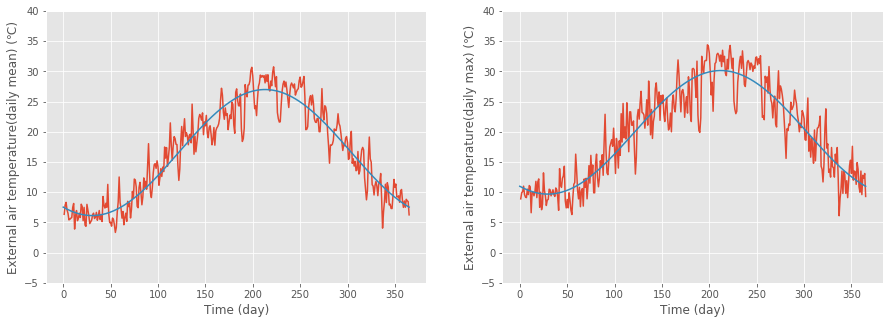

In [6]:
if __name__ == '__main__':
    
    location = '3639999'  #東京ID

    #気象データ読込
    w = WEA.Weather(location)
    #nhr = WEA.weather_input(location)[0]
    #nday = WEA.weather_input(location)[1]
    #tm = WEA.weather_input(location)[2]
    #tmp = WEA.weather_input(location)[3]

    #hcp_in = hcp_input(tmp, nhr, nday, tm)
    hcp_in = hcp_input(w.tmp, w.nhr, w.nday, w.tm)

    #暖房期間の計算
    para_h = heating_period(hcp_in)[6]
    day_h15_bgn = heating_period(hcp_in)[0]
    day_h15_end = heating_period(hcp_in)[1]
    print ('Regression coefficients(heating): a =', para_h[0], 'b =', para_h[1], 'c =', para_h[2])
    print ('Period(heating): begining day=', day_h15_bgn, ', ending day=', day_h15_end)

    dayh = heating_period(hcp_in)[2]
    ave_tmp = heating_period(hcp_in)[3]
    day_h = heating_period(hcp_in)[4]
    tmp_h = heating_period(hcp_in)[5]

    #冷房期間の計算
    para_c = cooling_period(hcp_in)[6]
    day_c23_bgn = cooling_period(hcp_in)[0]
    day_c23_end = cooling_period(hcp_in)[1]
    print ('Regression coefficients(cooling): a =', para_c[0], 'b =', para_c[1], 'c =', para_c[2])
    print ('Period(cooling): begining day=', day_c23_bgn, ', ending day=', day_c23_end)

    dayc = cooling_period(hcp_in)[2]
    max_tmp = cooling_period(hcp_in)[3]
    day_c = cooling_period(hcp_in)[4]
    tmp_c = cooling_period(hcp_in)[5]

    #グラフの描画
    graph_num = 2
    ax = np.empty(graph_num, dtype = np.object)
    fig = plt.figure(figsize = (15, 5 * ((graph_num + 1) // 2)))
    plt.style.use('ggplot')

    gpc = ['C0', 'C1']
    gxd = [[dayh, day_h], [dayc, day_c]]
    gyd = [[ave_tmp, tmp_h], [max_tmp, tmp_c]]
    gxl = 'Time (day)'
    gyl = ['External air temperature(daily mean) (℃)', 'External air temperature(daily max) (℃)']
    gyt = [5 * (i - 1) for i in range(10)]

    for i in range(graph_num):   
        ax[i] = fig.add_subplot((graph_num + 1) // 2, 2, i + 1)
        for j in range(2):
            ax[i].plot(gxd[i][j], gyd[i][j], color = gpc[j])
        ax[i].set_yticks(gyt)
        ax[i].set_xlabel(gxl, fontsize = 12)
        ax[i].set_ylabel(gyl[i], fontsize = 12)

    plt.show()